In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
import copy

# Setup

## Environment


In [9]:
env_name = 'Taxi-v2'

environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=500,
    representation_method='one_hot_encoding',
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Model

In [10]:
model_linear = linears.Linear(
    input_dimension=environment.get_input_dimension(), 
    n_actions=environment.n_actions,
)

model_mlp = mlps.MLP(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=100,
    n_hidden_layers=1,
    n_actions=environment.n_actions,
    dropout=0
)

model_rnn = rnns.RNN(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=50,
    n_actions=environment.n_actions,
    dropout=.3,
    truncate=10
)

model_attentive_rnn = rnns.AttentiveRNN(
    input_dimension=environment.get_input_dimension(),
    hidden_dimension=50,
    key_dimension=5,
    n_actions=environment.n_actions,
    dropout=.2,
    horizon=-1,
    truncate=10
)

## Agent

In [11]:
model = model_mlp
#model = model_linear

agent = agents.DQNAgent(
    model=model,
    optimiser=torch.optim.Adam(model.parameters(), lr=.1), 
    gamma=.99, 
    temperature=10, 
    algorithm='expsarsa', 
    n_actions=environment.n_actions,
    terminal_state=environment.max_obs
)

environment.agent = agent

Load an agent:

In [15]:
model.load_state_dict(torch.load('../saved/taxi/linear/state_dict.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(479)))

[10.180953   3.255734   5.2157855 10.733101   3.6761146 20.000134 ]


# Experiment

## Training

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/30


100%|###############################################################| 10/10 [01:33<00:00, 10.01s/it]


>> Training return : -514.72
>> Evaluation return : -201.40, steps : 200.00


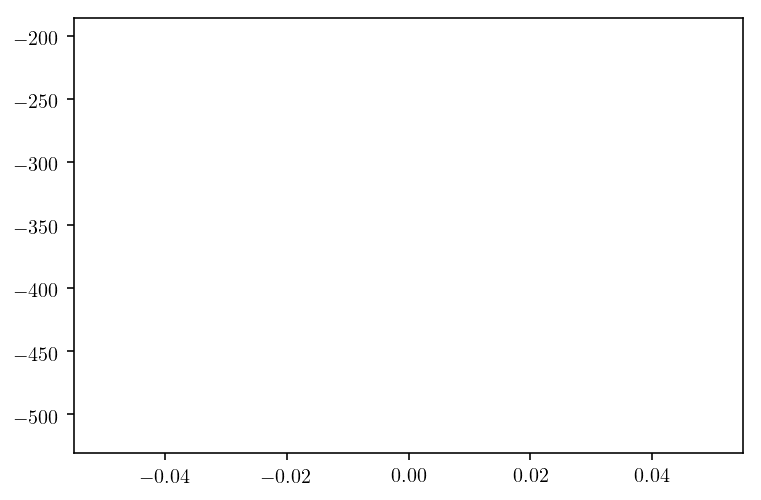

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 2/30


100%|###############################################################| 10/10 [01:30<00:00,  9.15s/it]


>> Training return : -457.49
>> Evaluation return : -201.31, steps : 200.00


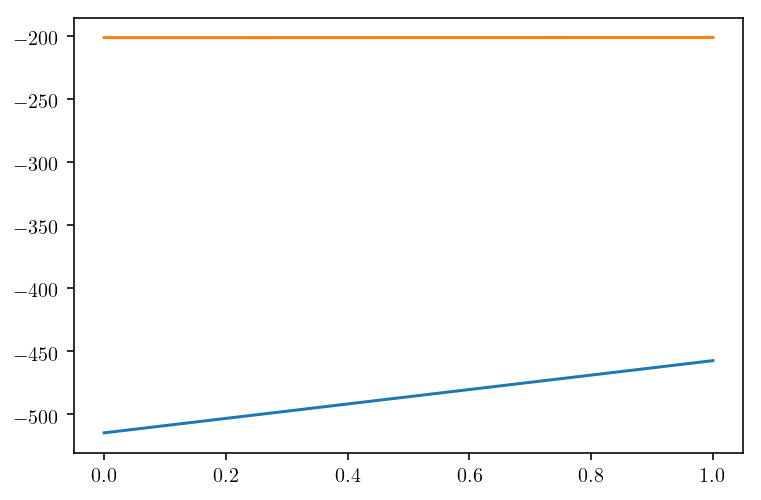

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 3/30


 90%|#########################################################6      | 9/10 [01:29<00:10, 10.11s/it]

In [ ]:
training, evaluation = environment.run(
    epochs=30,
    segments=10,
    episodes=100,
    wall_time=2,
    num_evaluation=200,
    batch_size=100,
    save_directory='../saved/taxi/mlp',
    log_directory='taxi_mlp',
    temp_decay = 0.94,
    display_return_curve=True,
)

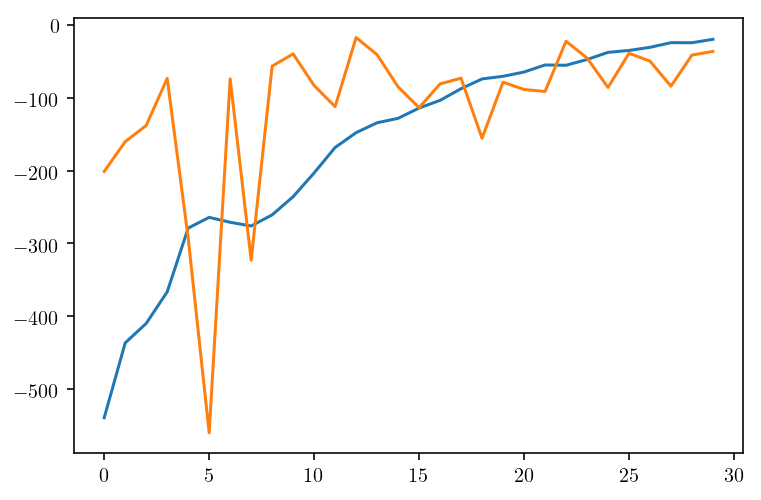

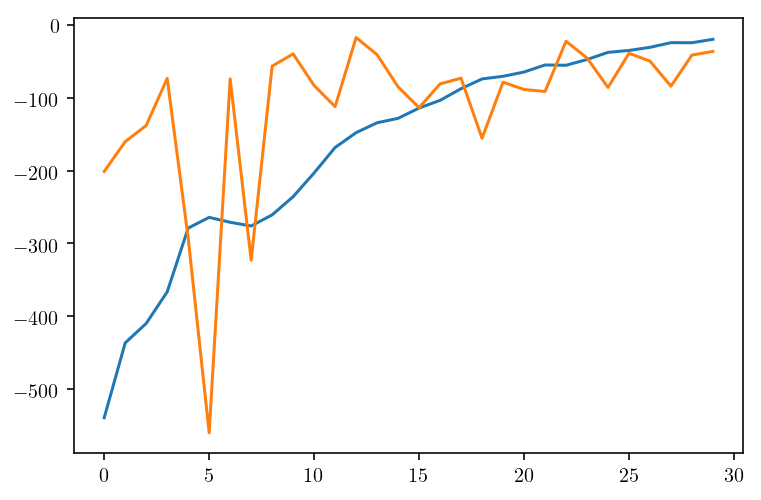

In [18]:

plt.figure()
plt.plot(training)
plt.plot(evaluation)
plt.show()

## Testing

In [17]:
environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
269
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
149
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
169
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
189
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
89
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
69
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
49
+---------+
|R: | : :G|
| : : : : |
| :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
369
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
469
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
489
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
469
+---------+
|R: | :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
429
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
449
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
429
+---------+
|R: | : :G|

In [15]:
environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 444
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 344
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 244
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 264
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 164
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 184
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 84
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 96
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 76
+---------+
|R: |_: :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:

## Save

In [41]:
environment.agent.save('../saved/taxi/mlp')